In [2]:
#########
# BASIC #
#########
import os
import sys
import platform
import warnings
from datetime import datetime
from collections import Counter
import calendar
from tqdm.notebook import tqdm_notebook

#############
# LOAD DATA #
#############
import numpy as np
import pandas as pd

#############################
# EXPLORATORY DATA ANALYSIS #
#############################
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

######################
# DATA PREPROCESSING #
######################
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
## NATURAL LANGUAGE PROCESSING 
from konlpy.tag import Komoran
from gensim.models import Word2Vec

In [3]:
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.4f}'.format
# plt.style.use('ggplot')
if platform.platform().split('-')[0] == 'Windows':
    mpl.rcParams['font.family'] = 'Malgun Gothic' # Windows에서는 한글이 나오게 하기 위해서
else: # macOS라고 가정
    mpl.rcParams['font.family'] = 'AppleGothic' # mac에서는 한글이 나오게 하기 위해서

mpl.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

In [4]:
data = dict()

In [6]:
data['train'] = pd.read_excel(r'../../data/01_제공데이터/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx',
                       header=1,
                       names=['방송일시', '노출(분)', '마더코드', '상품코드',
                              '상품명', '상품군', '판매단가', '취급액'],
                       thousands=',',
                       )
data['train'].index = pd.to_datetime(data['train']['방송일시'])
data['train'] = data['train'].drop('방송일시',axis=1)
data['train'] = data['train']['2019']
data['train']

,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
방송일시,,,,,,,
2019-01-01 06:00:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0000
2019-01-01 06:00:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0000
2019-01-01 06:20:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0000
2019-01-01 06:20:00,nan,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0000
2019-01-01 06:40:00,20.0000,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0000
...,...,...,...,...,...,...,...
2019-12-31 23:20:00,nan,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,1664000.0000
2019-12-31 23:40:00,20.0000,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,9149000.0000
2019-12-31 23:40:00,nan,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,15282000.0000


In [7]:
data['train']['연'] = data['train'].index.map(lambda x: x.year)
data['train']['월'] = data['train'].index.map(lambda x: x.month)
data['train']['주'] = data['train'].index.map(lambda x: x.week)
data['train']['일'] = data['train'].index.map(lambda x: x.day)
data['train']['시'] = data['train'].index.map(lambda x: x.hour)
data['train']['분'] = data['train'].index.map(lambda x: x.minute)
data['train']['요일'] = data['train'].index.map(lambda x: calendar.day_abbr[x.weekday()])

In [9]:
# 노출시간이 비어있을땐 앞을 보면 됨
data['train'] = data['train'].fillna(method='ffill')

In [10]:
def re_sub(series: pd.Series) -> pd.Series:
    series = series.str.replace(pat=r'[ㄱ-ㅎ]', repl=r'', regex=True)  # ㅋ 제거용
    series = series.str.replace(pat=r'[^\w\s]', repl=r'', regex=True)  # 특수문자 제거
    series = series.str.replace(pat=r'[ ]{2,}', repl=r' ', regex=True)  # 공백 제거
    series = series.str.replace(pat=r'[\u3000]+', repl=r'', regex=True)  # u3000 제거
    return series

In [11]:
train = data['train'][['상품명', '상품군']].copy()
train.상품명 = re_sub(train.상품명)

In [12]:
prod_names = (train[train.상품군 != '무형'].상품명 + ' ' + train[train.상품군 != '무형'].상품군).values # len(prod_names) > 1692 (무형 빼고)

In [13]:
komoran = Komoran(userdic='../../data/04_추가데이터/user_dict_0913.txt')
print(komoran.pos("KOMORAN은 한국어 형태소 분석기입니다."))

[('KOMORAN', 'SL'), ('은', 'JX'), ('한국어', 'NNP'), ('형태소', 'NNP'), ('분석기', 'NNG'), ('이', 'VCP'), ('ㅂ니다', 'EF'), ('.', 'SF')]


### Plot

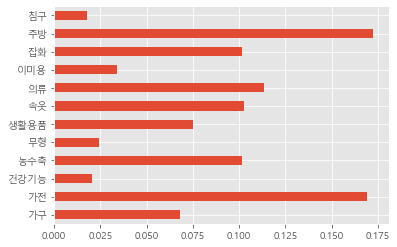

In [14]:
(data['train']['상품군'].value_counts().sort_index() / len(data['train']['상품군'])).plot(kind='barh')
plt.show()

In [15]:
data['train']['상품군'].value_counts().sort_index()

가구      2614
가전      6479
건강기능     790
농수축     3884
무형       932
생활용품    2877
속옷      3919
의류      4340
이미용     1305
잡화      3891
주방      6600
침구       669
Name: 상품군, dtype: int64

In [17]:
len(data['train']['상품군'])

38300

In [21]:
train = data['train'].copy()

In [22]:
train['indice'] = train.index

In [25]:
unique_time = train.drop_duplicates(subset='indice')

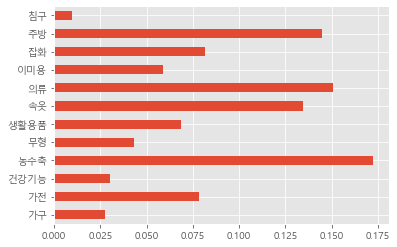

In [26]:
(unique_time['상품군'].value_counts().sort_index() / len(unique_time['상품군'])).plot(kind='barh')
plt.show()